In [1]:
import matplotlib.pyplot as plt

colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

# 예시:
# predicted와 example_output이 [1, 1, 30, 30] 크기의 텐서라고 가정
#show_grid_side_by_side(task_input, task_output, predicted)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)  # BatchNorm2d 대신 LayerNorm 사용

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)  # (B, E, P)
        x = x.transpose(1, 2)  # (B, P, E)
        x = self.norm(x)  # LayerNorm을 여기에서 사용
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, mlp_dim=3072, dropout=0.1):
        super().__init__()
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.layernorm3 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x_norm1 = self.layernorm1(x)
        attn_output, _ = self.attention(x_norm1, x_norm1, x_norm1)
        x = x + attn_output
        x = self.layernorm2(x)

        x_mlp_output = self.mlp(x)
        x = x + x_mlp_output
        x = self.layernorm3(x)
        return x

class ConvHead(nn.Module):
    def __init__(self, embed_dim=768, output_channels=11, output_size=30):
        super().__init__()
        self.conv = nn.Conv2d(embed_dim, output_channels, kernel_size=3, stride=1, padding=1)
        self.output_size = output_size

    def forward(self, x):
        B, P, E = x.shape
        H = W = int(P ** 0.5)  # Assumes square grid of patches
        x = x.transpose(1, 2).reshape(B, E, H, W)  # (B, E, H, W)
        x = self.conv(x)  # (B, output_channels, H, W)
        return nn.functional.interpolate(x, size=(self.output_size, self.output_size), mode='bilinear', align_corners=False)

class VisionTransformer(nn.Module):
    def __init__(self, img_size=30, patch_size=16, in_channels=3, embed_dim=768, num_heads=12, num_layers=12, output_channels=11, output_size=30, mlp_dim=3072, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        # self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.num_patches, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)
        self.transformer_encoders = nn.Sequential(
            *[TransformerEncoder(embed_dim, num_heads, mlp_dim, dropout) for _ in range(num_layers)]
        )
        self.norm = nn.LayerNorm(embed_dim)
        self.head = ConvHead(embed_dim, output_channels, output_size)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        # cls_tokens = self.cls_token.expand(B, -1, -1)
        # x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        x = self.transformer_encoders(x)
        x = self.norm(x)
        #print(x.shape)
        
        logits = self.head(x)
        return logits




In [4]:
# 모델 생성 및 출력
model_args =  {
    "img_size": 30,
    "patch_size": 6, # default: 16
    "in_channels": 1,
    "embed_dim": 512, # default: 768
    "num_heads": 8, # default: 12
    "num_layers": 8, # default: 12
    "mlp_dim": 2048, # default: 3072
    "dropout": 0.1,
    "output_channels": 11,
}

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(**model_args).to(device)
# 입력 텐서 생성
x = torch.randn(1, 1, 30, 30).to(device)

print(model(x).shape)

torch.Size([1, 11, 30, 30])


In [6]:
from thop import profile
from thop import clever_format

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
outer_model = VisionTransformer(**model_args).to(device)

# 입력 텐서 생성
x = torch.randn(1, 1, 30, 30).to(device)

# FLOPs 및 파라미터 수 계산
try:
    flops, params = profile(outer_model, inputs=(x,))
    flops, params = clever_format([flops, params], "%.3f")
    print(f"FLOPs: {flops}")
    print(f"파라미터 수: {params}")
except Exception as e:
    print(f"Error during profiling: {e}")
    print(f"Input shape: {x.shape}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPs: 422.490M
파라미터 수: 16.894M


In [7]:
# from bw_net_maml import BWNet_MAML

# model = BWNet_MAML(embed_size=1).to(device)

# # 입력 텐서 생성
# x = torch.randn(1, 1, 30, 30).to(device)

# # FLOPs 및 파라미터 수 계산
# try:
#     flops, params = profile(model, inputs=(x,))
#     flops, params = clever_format([flops, params], "%.3f")
#     print(f"FLOPs: {flops}")
#     print(f"파라미터 수: {params}")
# except Exception as e:
#     print(f"Error during profiling: {e}")
#     print(f"Input shape: {x.shape}")

In [8]:
import torch
weight = torch.ones(11).to('cuda')
weight[0] = 0.0005  # 0은 무시
print(weight)

tensor([5.0000e-04, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
       device='cuda:0')


Using cuda device
Epoch 1/500


Validation:  98%|█████████▊| 41/42 [02:57<00:04,  4.31s/it]

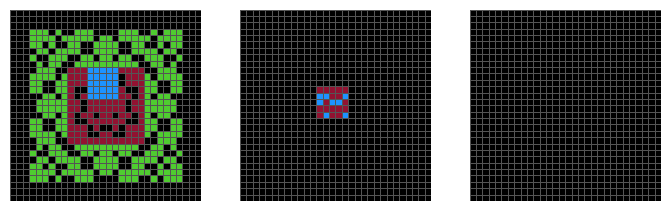

Validation: 100%|██████████| 42/42 [02:59<00:00,  4.28s/it]


Epoch 1/500, Loss: 13791.595703125, Accuracy: 46.33681535855449%
Epoch 2/500


Validation:  98%|█████████▊| 41/42 [02:55<00:04,  4.28s/it]

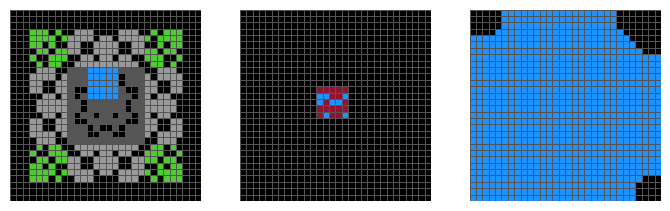

Validation: 100%|██████████| 42/42 [02:58<00:00,  4.25s/it]


Epoch 2/500, Loss: 13681.6884765625, Accuracy: 46.21329757199322%
Epoch 3/500


Validation:  98%|█████████▊| 41/42 [02:51<00:04,  4.26s/it]

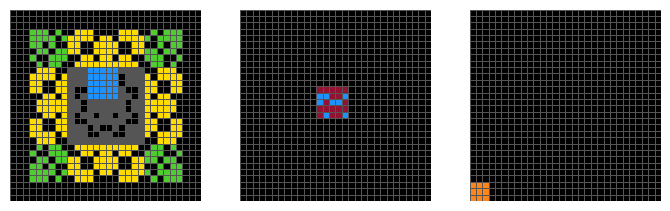

Validation: 100%|██████████| 42/42 [02:53<00:00,  4.14s/it]


Epoch 3/500, Loss: 14144.185546875, Accuracy: 45.80921795595709%
Epoch 4/500


Validation:  98%|█████████▊| 41/42 [02:52<00:04,  4.12s/it]

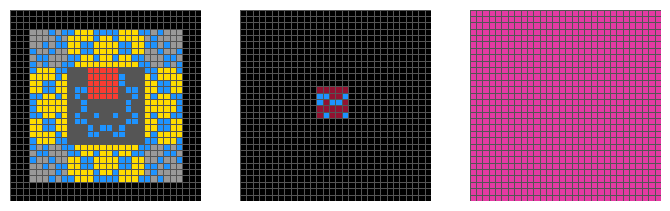

Validation: 100%|██████████| 42/42 [02:55<00:00,  4.17s/it]


Epoch 4/500, Loss: 13953.716796875, Accuracy: 47.24731789949181%
Epoch 5/500


Validation:  98%|█████████▊| 41/42 [02:49<00:04,  4.31s/it]

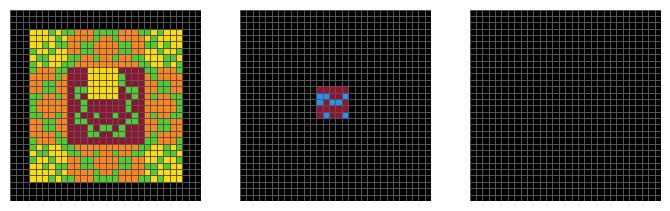

Validation: 100%|██████████| 42/42 [02:51<00:00,  4.09s/it]


Epoch 5/500, Loss: 13814.4169921875, Accuracy: 44.325239977413894%
Epoch 6/500


Validation:  98%|█████████▊| 41/42 [02:47<00:04,  4.08s/it]

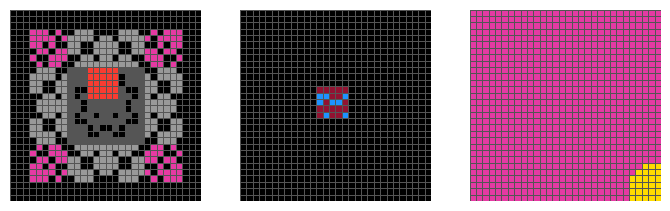

Validation: 100%|██████████| 42/42 [02:50<00:00,  4.06s/it]


Epoch 6/500, Loss: 14036.978515625, Accuracy: 44.515810276679844%
Epoch 7/500


Validation:  98%|█████████▊| 41/42 [02:48<00:04,  4.08s/it]

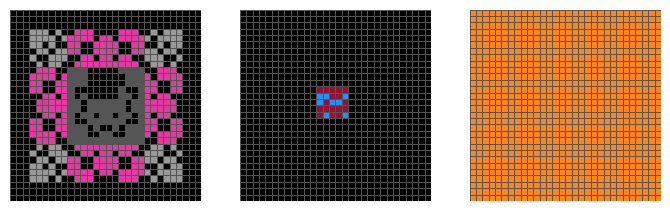

Validation: 100%|██████████| 42/42 [02:50<00:00,  4.07s/it]


Epoch 7/500, Loss: 14194.7041015625, Accuracy: 48.49661208356861%
Epoch 8/500


Validation:  98%|█████████▊| 41/42 [02:49<00:04,  4.23s/it]

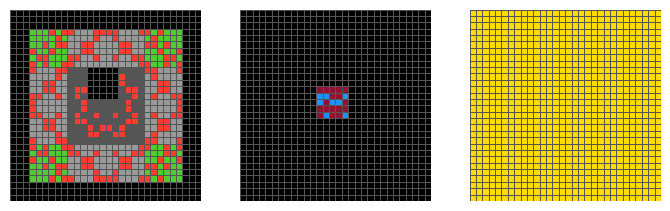

Validation: 100%|██████████| 42/42 [02:52<00:00,  4.10s/it]


Epoch 8/500, Loss: 13587.9296875, Accuracy: 45.535714285714285%
Epoch 9/500


Validation:  98%|█████████▊| 41/42 [02:49<00:04,  4.11s/it]

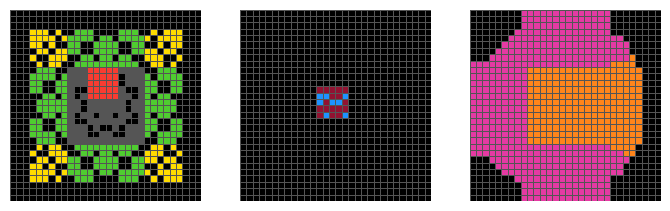

Validation: 100%|██████████| 42/42 [02:52<00:00,  4.10s/it]


Epoch 9/500, Loss: 13729.0185546875, Accuracy: 47.18026538678713%
Epoch 10/500


Validation:  98%|█████████▊| 41/42 [02:54<00:04,  4.16s/it]

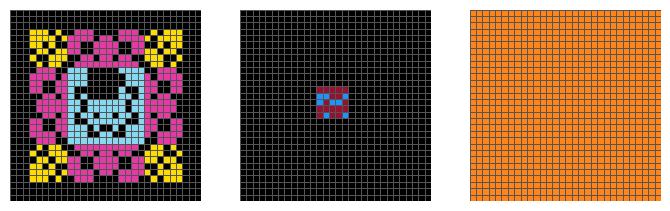

Validation: 100%|██████████| 42/42 [02:56<00:00,  4.21s/it]


Epoch 10/500, Loss: 14025.921875, Accuracy: 49.24301242236025%
Epoch 11/500


Validation:  98%|█████████▊| 41/42 [02:54<00:04,  4.27s/it]

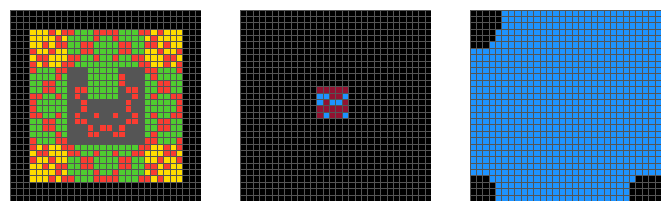

Validation: 100%|██████████| 42/42 [02:57<00:00,  4.22s/it]


Epoch 11/500, Loss: 13981.552734375, Accuracy: 44.14172783738001%
Epoch 12/500


Validation:  98%|█████████▊| 41/42 [02:51<00:04,  4.23s/it]

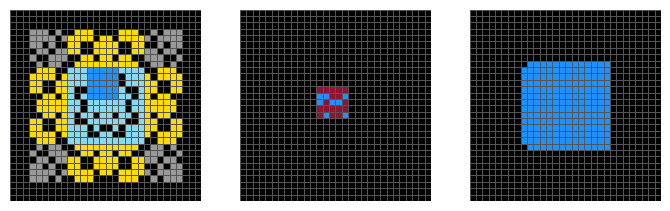

Validation: 100%|██████████| 42/42 [02:54<00:00,  4.15s/it]


Epoch 12/500, Loss: 13580.525390625, Accuracy: 45.6345285149633%
Epoch 13/500


Validation:  98%|█████████▊| 41/42 [02:54<00:04,  4.36s/it]

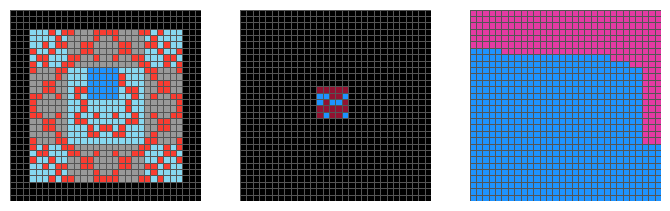

Validation: 100%|██████████| 42/42 [02:56<00:00,  4.21s/it]


Epoch 13/500, Loss: 13193.451171875, Accuracy: 45.45807453416149%
Epoch 14/500


Validation:  98%|█████████▊| 41/42 [02:49<00:04,  4.11s/it]

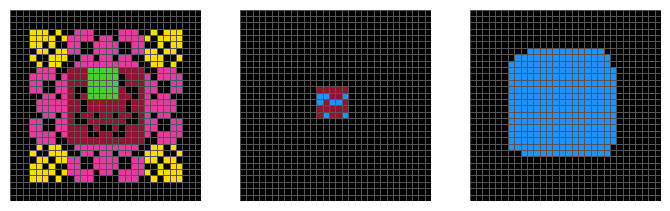

Validation: 100%|██████████| 42/42 [02:52<00:00,  4.10s/it]


Epoch 14/500, Loss: 14110.1767578125, Accuracy: 49.05067758328628%
Epoch 15/500


Validation:  98%|█████████▊| 41/42 [02:49<00:04,  4.09s/it]

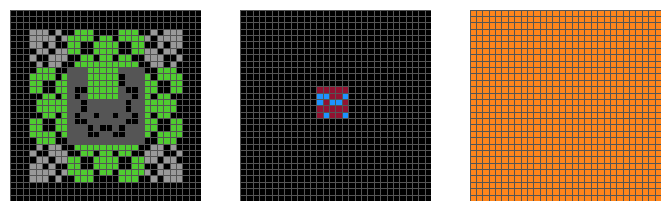

Validation: 100%|██████████| 42/42 [02:51<00:00,  4.09s/it]


Epoch 15/500, Loss: 13566.173828125, Accuracy: 47.79608977978543%
Epoch 16/500


Validation:  98%|█████████▊| 41/42 [02:48<00:04,  4.15s/it]

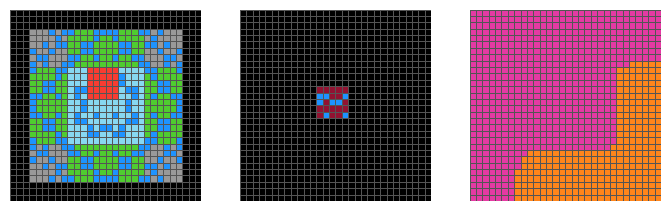

Validation: 100%|██████████| 42/42 [02:51<00:00,  4.08s/it]


Epoch 16/500, Loss: 13308.9208984375, Accuracy: 43.43061829474873%
Epoch 17/500


Validation:  98%|█████████▊| 41/42 [02:49<00:04,  4.08s/it]

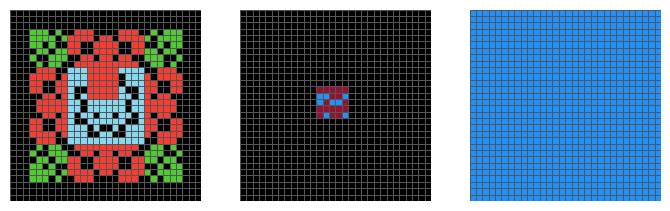

Validation: 100%|██████████| 42/42 [02:52<00:00,  4.10s/it]


Epoch 17/500, Loss: 13691.224609375, Accuracy: 46.42327780914737%
Epoch 18/500


Validation:  98%|█████████▊| 41/42 [02:52<00:04,  4.14s/it]

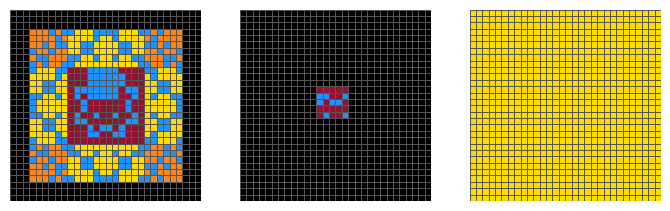

Validation: 100%|██████████| 42/42 [02:55<00:00,  4.17s/it]


Epoch 18/500, Loss: 13992.8876953125, Accuracy: 45.33808582721626%
Epoch 19/500


Validation:  98%|█████████▊| 41/42 [02:54<00:04,  4.16s/it]

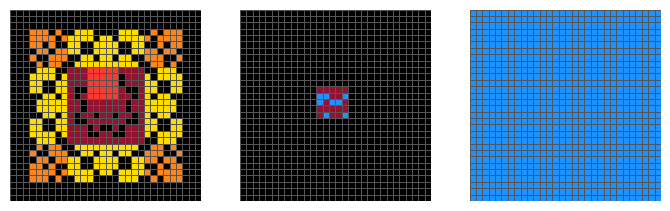

Validation: 100%|██████████| 42/42 [02:57<00:00,  4.22s/it]


Epoch 19/500, Loss: 13704.638671875, Accuracy: 42.089568040654996%
Epoch 20/500


Validation:  98%|█████████▊| 41/42 [02:54<00:04,  4.27s/it]

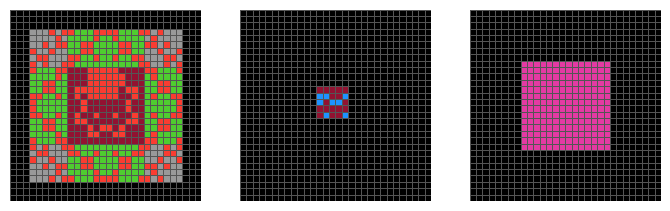

Validation: 100%|██████████| 42/42 [02:57<00:00,  4.22s/it]


Epoch 20/500, Loss: 14007.3447265625, Accuracy: 47.5296442687747%
Epoch 21/500


Validation:  98%|█████████▊| 41/42 [02:50<00:04,  4.10s/it]

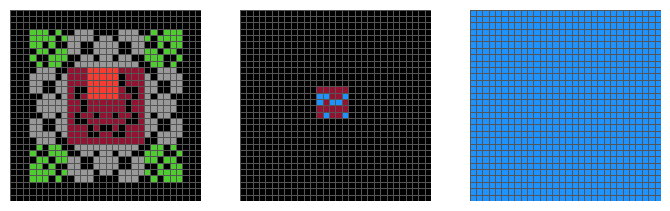

Validation: 100%|██████████| 42/42 [02:52<00:00,  4.12s/it]


Epoch 21/500, Loss: 13034.1123046875, Accuracy: 45.20574534161491%
Epoch 22/500


Validation:  98%|█████████▊| 41/42 [02:49<00:04,  4.34s/it]

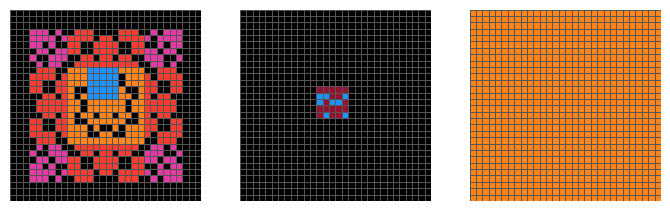

Validation: 100%|██████████| 42/42 [02:52<00:00,  4.10s/it]


Epoch 22/500, Loss: 13476.240234375, Accuracy: 47.033808582721626%
Epoch 23/500


Validation:  98%|█████████▊| 41/42 [02:48<00:04,  4.07s/it]

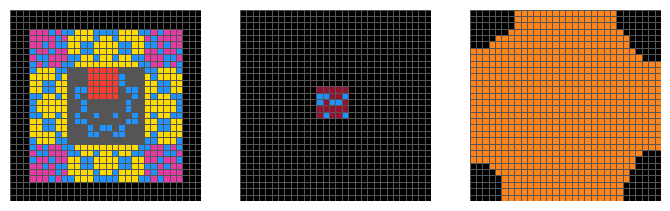

Validation: 100%|██████████| 42/42 [02:50<00:00,  4.07s/it]


Epoch 23/500, Loss: 13711.8662109375, Accuracy: 46.19035855448899%
Epoch 24/500


Validation:  98%|█████████▊| 41/42 [02:49<00:04,  4.09s/it]

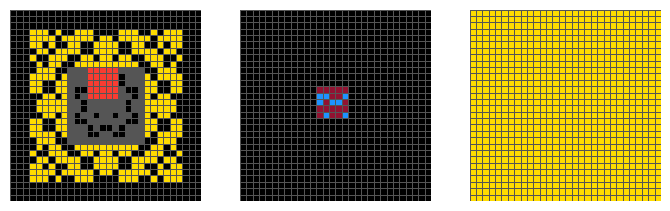

Validation: 100%|██████████| 42/42 [02:52<00:00,  4.10s/it]


Epoch 24/500, Loss: 13675.119140625, Accuracy: 44.43464144551101%
Epoch 25/500


Validation:  98%|█████████▊| 41/42 [02:49<00:04,  4.14s/it]

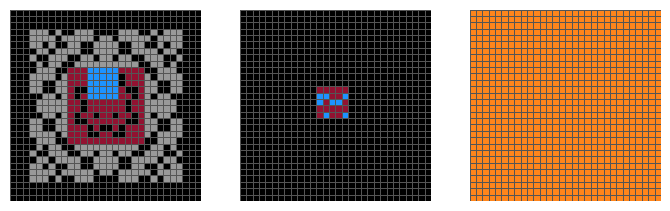

Validation: 100%|██████████| 42/42 [02:52<00:00,  4.10s/it]


Epoch 25/500, Loss: 13761.4873046875, Accuracy: 46.816770186335404%
Epoch 26/500


Validation:  98%|█████████▊| 41/42 [02:49<00:04,  4.10s/it]

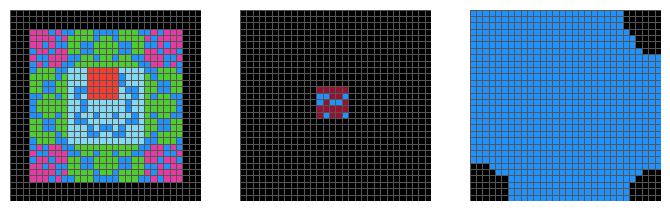

Validation: 100%|██████████| 42/42 [02:52<00:00,  4.10s/it]


Epoch 26/500, Loss: 13577.8701171875, Accuracy: 47.411420101637496%
Epoch 27/500


Validation:  98%|█████████▊| 41/42 [02:53<00:04,  4.15s/it]

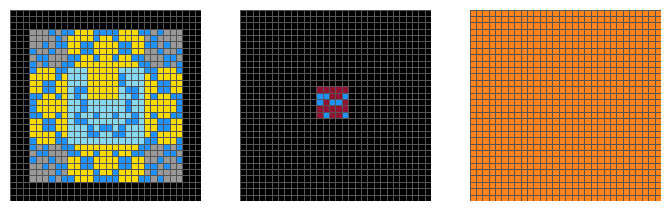

Validation: 100%|██████████| 42/42 [02:56<00:00,  4.19s/it]


Epoch 27/500, Loss: 13579.3623046875, Accuracy: 48.19134669678148%
Epoch 28/500


Validation:  98%|█████████▊| 41/42 [02:51<00:04,  4.10s/it]

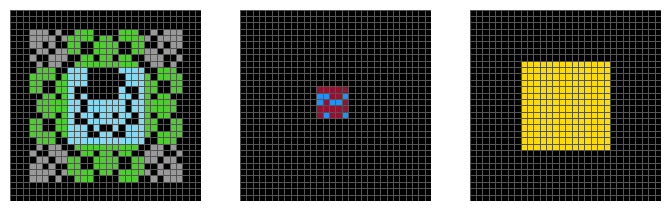

Validation: 100%|██████████| 42/42 [02:54<00:00,  4.14s/it]


Epoch 28/500, Loss: 13363.6123046875, Accuracy: 47.20320440429136%
Epoch 29/500


Validation:  98%|█████████▊| 41/42 [02:51<00:04,  4.24s/it]

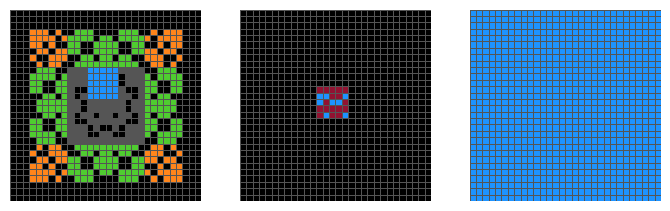

Validation: 100%|██████████| 42/42 [02:54<00:00,  4.15s/it]


Epoch 29/500, Loss: 13822.685546875, Accuracy: 50.24174195369847%
Epoch 30/500


Validation:  98%|█████████▊| 41/42 [02:50<00:04,  4.24s/it]

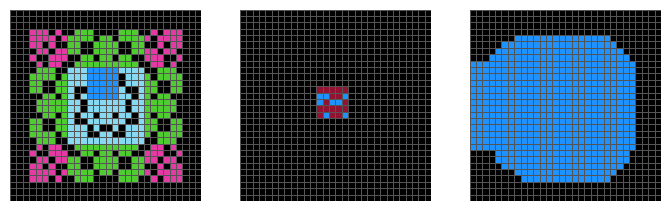

Validation: 100%|██████████| 42/42 [02:52<00:00,  4.12s/it]


Epoch 30/500, Loss: 13600.740234375, Accuracy: 44.96223884810841%
Epoch 31/500


Validation:  98%|█████████▊| 41/42 [02:52<00:04,  4.41s/it]

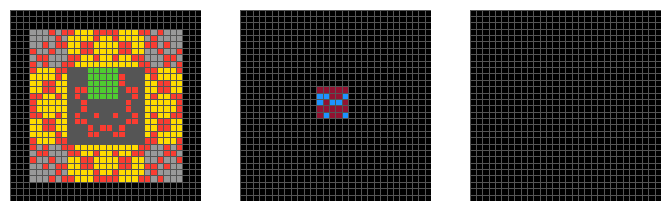

Validation: 100%|██████████| 42/42 [02:54<00:00,  4.16s/it]


Epoch 31/500, Loss: 13389.060546875, Accuracy: 50.26468097120271%
Epoch 32/500


Validation:  98%|█████████▊| 41/42 [02:49<00:04,  4.06s/it]

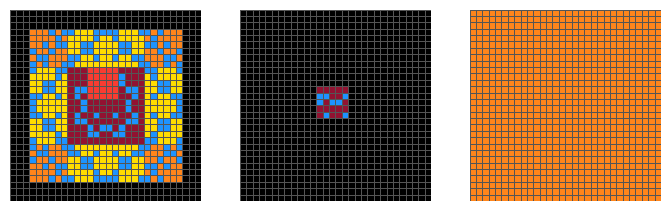

Validation: 100%|██████████| 42/42 [02:51<00:00,  4.09s/it]


Epoch 32/500, Loss: 13979.654296875, Accuracy: 46.721485036702425%
Epoch 33/500


Validation:  98%|█████████▊| 41/42 [02:49<00:04,  4.14s/it]

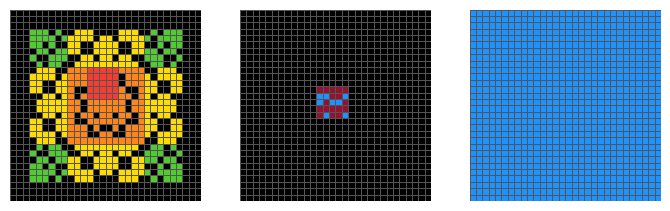

Validation: 100%|██████████| 42/42 [02:52<00:00,  4.11s/it]


Epoch 33/500, Loss: 14017.21875, Accuracy: 47.868435911914176%
Epoch 34/500


Validation:  98%|█████████▊| 41/42 [02:51<00:04,  4.22s/it]

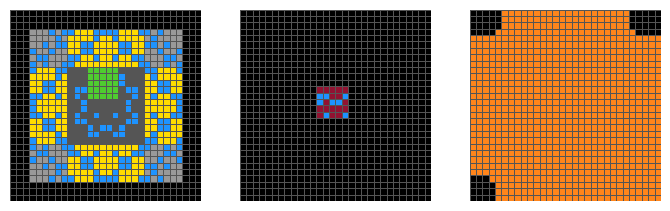

Validation: 100%|██████████| 42/42 [02:54<00:00,  4.15s/it]


Epoch 34/500, Loss: 13491.068359375, Accuracy: 46.64560982495765%
Epoch 35/500


Validation:  33%|███▎      | 14/42 [01:01<02:03,  4.42s/it]

In [9]:
from bw_net_maml import BWNet_MAML
import torch
from torch.utils.data import DataLoader
from dataloader_sw import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import gc


colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 500,
    'task_numbers': 10, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20, #equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
    'embed_size': 1,
}


def criterion(y_pred, y):
    y = y.long().squeeze(1)
    weight = torch.ones(model_args['output_channels']).to(y.device)
    weight[0] = 0.005
    ce = F.cross_entropy(y_pred, y, weight=weight)
    return ce

# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device  
print(f'Using {device} device')



train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

# Outer Model 정의
outer_model =  VisionTransformer(**model_args).to(device)
outer_optimizer = optim.AdamW(outer_model.parameters(), lr=kwargs['outer_lr'])

# Inner Loop 업데이트 함수
def inner_loop_update(model, example_input, example_output, inner_optimizer, criterion, steps):
    for _ in range(steps):
        model.train()
        prediction = model(example_input)
        loss = criterion(prediction, example_output)

        inner_optimizer.zero_grad()
        loss.backward()
        inner_optimizer.step()

# Training Loop
for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    total_loss = 0
    outer_model.train()
    
    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

        task_losses = []
        for task_number in range(input_tensor.shape[0]):
            inner_model = deepcopy(outer_model)
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])

            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                              inner_optimizer, criterion, kwargs['example_data_num'])
            
            inner_model.eval()
            task_prediction = inner_model(input_tensor[task_number])
            task_loss = criterion(task_prediction, output_tensor[task_number])
            task_losses.append(task_loss)
        
        meta_loss = torch.stack(task_losses).mean()
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()

        del meta_loss, task_losses
        gc.collect()
        torch.cuda.empty_cache()

    # Validation Loop
    outer_model.eval()
    validation_correct = 0
    validation_total_samples = 0
    total_loss = 0

    for batch_idx, data in enumerate(tqdm(eval_loader, desc='Validation')):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

        for task_number in range(input_tensor.shape[0]):
            inner_model = deepcopy(outer_model)
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])

            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                              inner_optimizer, criterion, kwargs['example_data_num'])

            with torch.no_grad():
                inner_model.eval()
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                task_prediction = inner_model(task_input)
                task_loss = criterion(task_prediction, task_output)
                total_loss += task_loss

                prediction_class = torch.argmax(task_prediction, dim=1, keepdim=True)

                mask = task_output != 0
                correct_predictions = (prediction_class == task_output) & mask
                validation_correct += correct_predictions.sum().item()
                validation_total_samples += mask.sum().item()

                if batch_idx == len(eval_loader) - 1 and task_number == input_tensor.shape[0] - 1:
                    show_grid_side_by_side(task_input.cpu(), task_output.cpu(), prediction_class.cpu())

            del inner_model, inner_optimizer, task_input, task_output, task_prediction, mask, correct_predictions
            gc.collect()
            torch.cuda.empty_cache()

    accuracy = 100 * validation_correct / validation_total_samples if validation_total_samples > 0 else 0
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {total_loss.item().mean()}, Accuracy: {accuracy}%')

    torch.cuda.empty_cache()